In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import wfdb
from collections import Counter

# Set style for plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Function to load MIT-BIH data from the data folder
def load_mitbih_data(data_dir):
    """
    Load MIT-BIH Arrhythmia Database records from the data directory
    
    Parameters:
    data_dir (str): Path to the directory containing the MIT-BIH data files
    
    Returns:
    dict: Dictionary containing the loaded records and annotations
    """
    records = []
    annotations = []
    record_names = []
    
    # Find all record files (.dat) in the directory
    for file in os.listdir(data_dir):
        if file.endswith('.dat'):
            record_name = os.path.splitext(file)[0]
            record_path = os.path.join(data_dir, record_name)
            
            try:
                # Load record and annotation
                record = wfdb.rdrecord(record_path)
                annotation = wfdb.rdann(record_path, 'atr')
                
                records.append(record)
                annotations.append(annotation)
                record_names.append(record_name)
                
                print(f"Loaded record: {record_name}")
            except Exception as e:
                print(f"Error loading record {record_name}: {e}")
    
    return {
        'records': records,
        'annotations': annotations,
        'record_names': record_names
    }


In [3]:

# Function to extract heartbeats from records
def extract_heartbeats(records, annotations, window_size=250):
    """
    Extract heartbeat segments from the records based on annotations
    
    Parameters:
    records (list): List of record objects
    annotations (list): List of annotation objects
    window_size (int): Size of the window around each annotation point (default: 250)
    
    Returns:
    dict: Dictionary containing heartbeat segments and their labels
    """
    heartbeats = []
    labels = []
    record_ids = []
    
    for i, (record, annotation) in enumerate(zip(records, annotations)):
        # Get signal data
        signal = record.p_signal
        
        # Get annotation indices and symbols
        ann_indices = annotation.sample
        ann_symbols = annotation.symbol
        
        for idx, symbol in zip(ann_indices, ann_symbols):
            # Extract window around the annotation point
            start_idx = max(0, idx - window_size // 2)
            end_idx = min(len(signal), idx + window_size // 2)
            
            # Skip if the window is too small
            if end_idx - start_idx < window_size:
                continue
            
            # Extract the segment
            segment = signal[start_idx:end_idx, 0]  # Using first channel
            
            heartbeats.append(segment)
            labels.append(symbol)
            record_ids.append(i)
    
    return {
        'heartbeats': np.array(heartbeats),
        'labels': np.array(labels),
        'record_ids': np.array(record_ids)
    }


In [4]:

# Function to plot distribution of heartbeat labels
def plot_label_distribution(labels):
    """
    Plot the distribution of heartbeat labels
    
    Parameters:
    labels (array): Array of heartbeat labels
    """
    label_counts = Counter(labels)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(label_counts.keys(), label_counts.values())
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height}', ha='center', va='bottom')
    
    plt.title('Distribution of Heartbeat Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print label descriptions
    print("\nMIT-BIH Annotation Symbol Meanings:")
    print("N: Normal beat")
    print("L: Left bundle branch block beat")
    print("R: Right bundle branch block beat")
    print("A: Atrial premature beat")
    print("V: Premature ventricular contraction")
    print("/: Paced beat")
    print("!: Ventricular flutter wave")
    print("E: Ventricular escape beat")
    print("j: Nodal (junctional) escape beat")
    print("a: Aberrated atrial premature beat")
    print("J: Nodal (junctional) premature beat")
    print("S: Supraventricular premature beat")
    print("F: Fusion of ventricular and normal beat")
    print("e: Atrial escape beat")
    print("Q: Unclassifiable beat")


In [5]:

# Function to plot sample heartbeats for each label
def plot_sample_heartbeats(heartbeats, labels, num_samples=3):
    """
    Plot sample heartbeats for each label
    
    Parameters:
    heartbeats (array): Array of heartbeat segments
    labels (array): Array of heartbeat labels
    num_samples (int): Number of samples to plot for each label
    """
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        # Get indices for current label
        indices = np.where(labels == label)[0]
        
        # Skip if fewer than requested samples
        if len(indices) < num_samples:
            continue
        
        # Select random samples
        sample_indices = np.random.choice(indices, num_samples, replace=False)
        
        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(sample_indices):
            plt.subplot(1, num_samples, i+1)
            plt.plot(heartbeats[idx])
            plt.title(f'Label: {label}')
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
        
        plt.tight_layout()
        plt.show()


In [6]:

# Function to perform PCA analysis on heartbeats
def perform_pca_analysis(heartbeats, labels, n_components=2):
    """
    Perform PCA analysis on heartbeat segments
    
    Parameters:
    heartbeats (array): Array of heartbeat segments
    labels (array): Array of heartbeat labels
    n_components (int): Number of PCA components
    
    Returns:
    array: PCA transformed data
    """
    # Standardize the data
    scaler = StandardScaler()
    heartbeats_scaled = scaler.fit_transform(heartbeats)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    heartbeats_pca = pca.fit_transform(heartbeats_scaled)
    
    # Plot PCA results
    plt.figure(figsize=(12, 10))
    
    # Get most common labels for better visualization
    label_counts = Counter(labels)
    common_labels = [label for label, _ in label_counts.most_common(5)]
    
    for label in common_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(heartbeats_pca[indices, 0], heartbeats_pca[indices, 1], label=label, alpha=0.7)
    
    plt.title('PCA of Heartbeat Segments')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return heartbeats_pca


In [ ]:
# Function to perform robust PCA analysis on heartbeats with PCP
def perform_advanced_robust_pca(heartbeats, labels, n_components=2, random_state=42):
    """
    Perform advanced Robust PCA using principal component pursuit (PCP) on heartbeat segments.
    This implementation separates the low-rank component from sparse noise.
    
    Parameters:
    heartbeats (array): Array of heartbeat segments
    labels (array): Array of heartbeat labels
    n_components (int): Number of PCA components
    random_state (int): Random state for reproducibility
    
    Returns:
    tuple: (low_rank_component, sparse_component, PCA transformed data)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from collections import Counter
    import scipy.sparse as sparse
    from scipy.linalg import svd
    from sklearn.decomposition import PCA
    
    # Function to perform Principal Component Pursuit (PCP)
    def rpca(M, lam=0.1, mu=1.0, max_iter=100, tol=1e-7):
        """
        Robust PCA via Principal Component Pursuit (PCP)
        
        Decomposes a matrix M = L + S where L is low rank and S is sparse
        
        Parameters:
        M (ndarray): The input matrix to be decomposed
        lam (float): Regularization parameter for sparsity
        mu (float): Augmented Lagrangian parameter
        max_iter (int): Maximum number of iterations
        tol (float): Convergence tolerance
        
        Returns:
        tuple: (L, S) where L is the low rank component and S is the sparse component
        """
        # Initialize variables
        L = np.zeros(M.shape)
        S = np.zeros(M.shape)
        Y = np.zeros(M.shape)
        
        # Frobenius norm
        norm_M = np.linalg.norm(M, 'fro')
        
        for i in range(max_iter):
            # Update L
            U, sigma, Vt = svd(M - S + (1/mu) * Y, full_matrices=False)
            sigma_threshold = np.maximum(sigma - 1/mu, 0)
            L_new = U @ np.diag(sigma_threshold) @ Vt
            
            # Update S
            temp = M - L_new + (1/mu) * Y
            S_new = np.sign(temp) * np.maximum(np.abs(temp) - lam/mu, 0)
            
            # Update Y
            Y = Y + mu * (M - L_new - S_new)
            
            # Check convergence
            err = np.linalg.norm(M - L_new - S_new, 'fro') / norm_M
            if err < tol:
                break
                
            L, S = L_new, S_new
        
        return L, S
    
    # Scale data to [0, 1] range to help with the RPCA convergence
    min_val = np.min(heartbeats)
    max_val = np.max(heartbeats)
    scaled_heartbeats = (heartbeats - min_val) / (max_val - min_val)
    
    # Apply robust PCA via PCP
    print("Performing Robust PCA decomposition (this may take a while)...")
    low_rank, sparse = rpca(scaled_heartbeats)
    
    # Apply standard PCA on the low-rank component
    pca = PCA(n_components=n_components, random_state=random_state)
    heartbeats_pca = pca.fit_transform(low_rank)
    
    # Plot Robust PCA results
    plt.figure(figsize=(15, 10))
    
    # Create subplots for the decomposition
    plt.subplot(221)
    plt.title('Original Sample')
    sample_idx = np.random.randint(0, len(heartbeats))
    plt.plot(scaled_heartbeats[sample_idx])
    
    plt.subplot(222)
    plt.title('Low Rank Component (Clean Signal)')
    plt.plot(low_rank[sample_idx])
    
    plt.subplot(223)
    plt.title('Sparse Component (Noise/Artifacts)')
    plt.plot(sparse[sample_idx])
    
    plt.subplot(224)
    
    # Get most common labels for better visualization
    label_counts = Counter(labels)
    common_labels = [label for label, _ in label_counts.most_common(5)]
    
    for label in common_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(heartbeats_pca[indices, 0], heartbeats_pca[indices, 1], 
                   label=label, alpha=0.7)
    
    plt.title('Robust PCA Projection')
    plt.xlabel(f'Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return low_rank, sparse, heartbeats_pca

In [7]:

# Function to compute and display basic statistics
def compute_heartbeat_statistics(heartbeats, labels):
    """
    Compute basic statistics for heartbeat segments
    
    Parameters:
    heartbeats (array): Array of heartbeat segments
    labels (array): Array of heartbeat labels
    """
    unique_labels = np.unique(labels)
    
    # Create dataframe to store statistics
    stats_df = pd.DataFrame(
        index=unique_labels,
        columns=['Count', 'Mean Amplitude', 'Std Amplitude', 'Min', 'Max', 'Median']
    )
    
    for label in unique_labels:
        # Get heartbeats for current label
        label_heartbeats = heartbeats[labels == label]
        
        # Compute statistics
        stats_df.loc[label, 'Count'] = len(label_heartbeats)
        stats_df.loc[label, 'Mean Amplitude'] = np.mean(label_heartbeats)
        stats_df.loc[label, 'Std Amplitude'] = np.std(label_heartbeats)
        stats_df.loc[label, 'Min'] = np.min(label_heartbeats)
        stats_df.loc[label, 'Max'] = np.max(label_heartbeats)
        stats_df.loc[label, 'Median'] = np.median(label_heartbeats)
    
    return stats_df


In [9]:

# Function to plot feature correlations between heartbeats
def plot_heartbeat_correlations(heartbeats, labels, top_n_labels=5):
    """
    Plot correlation matrix between average heartbeats of different labels
    
    Parameters:
    heartbeats (array): Array of heartbeat segments
    labels (array): Array of heartbeat labels
    top_n_labels (int): Number of most common labels to use
    """
    # Get most common labels
    label_counts = Counter(labels)
    common_labels = [label for label, _ in label_counts.most_common(top_n_labels)]
    
    # Compute average heartbeat for each label
    avg_heartbeats = {}
    for label in common_labels:
        label_heartbeats = heartbeats[labels == label]
        avg_heartbeats[label] = np.mean(label_heartbeats, axis=0)
    
    # Create correlation matrix
    corr_matrix = np.zeros((len(common_labels), len(common_labels)))
    for i, label1 in enumerate(common_labels):
        for j, label2 in enumerate(common_labels):
            corr, _ = stats.pearsonr(avg_heartbeats[label1], avg_heartbeats[label2])
            corr_matrix[i, j] = corr
    
    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=common_labels, yticklabels=common_labels)
    plt.title('Correlation Between Average Heartbeats')
    plt.tight_layout()
    plt.show()

# Main function to run the EDA
data_dir="/home/abdelilah-younsi/Desktop/master X-2024-2025/datacamp-master-main/project/datachall/mit-bih-arrhythmia-database-1.0.0"

print("Loading MIT-BIH ECG data...")
data = load_mitbih_data(data_dir)
    
if not data['records']:
    print("No records found. Please check the data directory.")
    
print(f"\nFound {len(data['records'])} records.")
  

Loading MIT-BIH ECG data...
Loaded record: 219
Loaded record: 223
Loaded record: 213
Loaded record: 117
Loaded record: 118
Loaded record: 102
Loaded record: 234
Loaded record: 212
Loaded record: 230
Loaded record: 101
Loaded record: 107
Loaded record: 108
Loaded record: 208
Loaded record: 207
Loaded record: 200
Loaded record: 113
Loaded record: 104
Loaded record: 121
Loaded record: 201
Loaded record: 221
Loaded record: 215
Loaded record: 222
Loaded record: 122
Loaded record: 115
Loaded record: 205
Loaded record: 114
Loaded record: 231
Loaded record: 124
Loaded record: 103
Loaded record: 109
Loaded record: 217
Loaded record: 112
Loaded record: 111
Loaded record: 106
Loaded record: 123
Loaded record: 232
Loaded record: 210
Loaded record: 220
Loaded record: 119
Loaded record: 100
Loaded record: 233
Loaded record: 203
Loaded record: 228
Loaded record: 105
Loaded record: 214
Loaded record: 209
Loaded record: 202
Loaded record: 116

Found 48 records.


In [11]:
  
    # Extract heartbeats
print("\nExtracting heartbeats...")
heartbeat_data = extract_heartbeats(data['records'], data['annotations'])
    
heartbeats = heartbeat_data['heartbeats']
labels = heartbeat_data['labels']
record_ids = heartbeat_data['record_ids']
    
print(f"Extracted {len(heartbeats)} heartbeats with {len(np.unique(labels))} unique labels.")


Extracting heartbeats...
Extracted 112561 heartbeats with 23 unique labels.



Plotting label distribution...


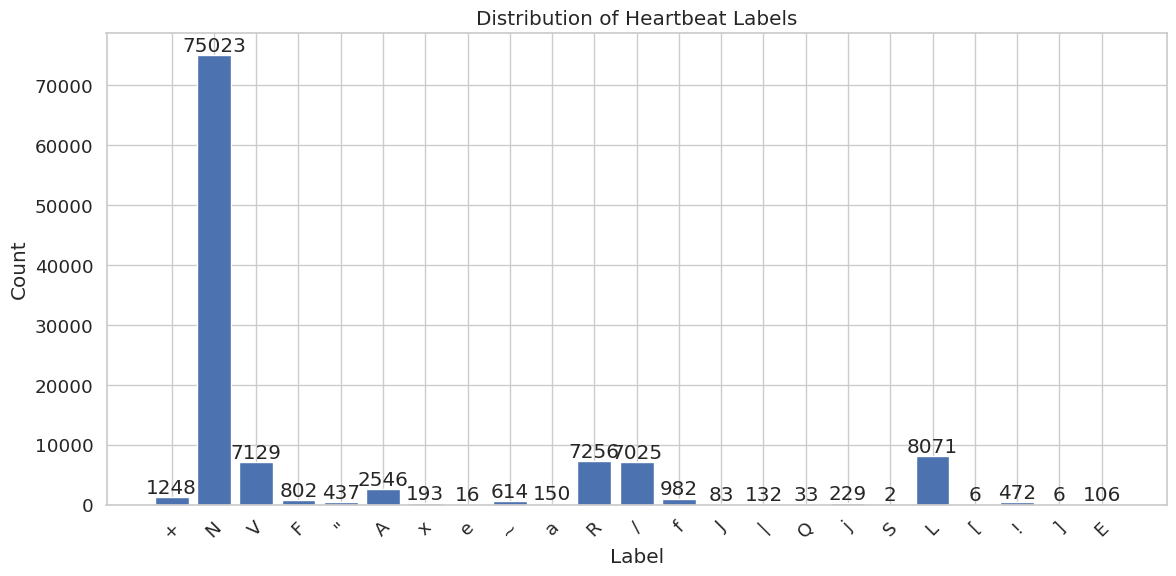


MIT-BIH Annotation Symbol Meanings:
N: Normal beat
L: Left bundle branch block beat
R: Right bundle branch block beat
A: Atrial premature beat
V: Premature ventricular contraction
/: Paced beat
!: Ventricular flutter wave
E: Ventricular escape beat
j: Nodal (junctional) escape beat
a: Aberrated atrial premature beat
J: Nodal (junctional) premature beat
S: Supraventricular premature beat
F: Fusion of ventricular and normal beat
e: Atrial escape beat
Q: Unclassifiable beat


In [15]:

    # Plot label distribution
print("\nPlotting label distribution...")
plot_label_distribution(labels)
    
    

In [16]:
print("\nComputing heartbeat statistics...")
stats_df = compute_heartbeat_statistics(heartbeats, labels)
print(stats_df)


Computing heartbeat statistics...
   Count Mean Amplitude Std Amplitude    Min    Max Median
!    472      -0.118388      0.362986 -1.805   1.17  -0.13
"    437      -0.150577      0.223284 -1.385  0.835 -0.185
+   1248      -0.237566      0.508195   -2.8   2.95 -0.225
/   7025      -0.248926      0.597296 -3.365  3.465  -0.28
A   2546      -0.206785      0.310497 -2.755  2.835 -0.195
E    106      -0.131223       0.31558 -0.735  1.105 -0.185
F    802      -0.172535      0.610867 -2.405  3.285 -0.245
J     83      -0.418301      0.556441  -1.87   2.23 -0.305
L   8071      -0.190356      0.426446 -3.955   3.13  -0.23
N  75023      -0.334699      0.444221  -5.12  5.115   -0.3
Q     33      -0.163212      0.771591 -3.485  2.795 -0.225
R   7256      -0.502288      0.530032  -3.09  2.595 -0.475
S      2       -0.16807      0.280316  -0.54  1.545  -0.22
V   7129       -0.26224      0.692885 -3.605   3.64  -0.25
[      6        0.07923      0.463798 -1.805    1.1  0.135
]      6       0.1755


Plotting sample heartbeats for each label...


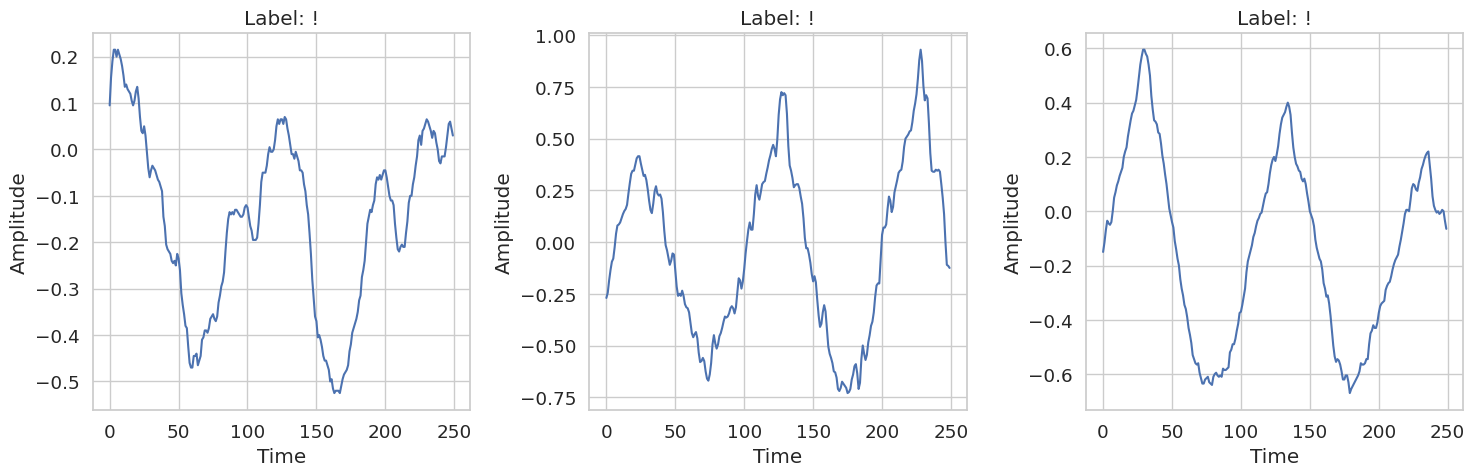

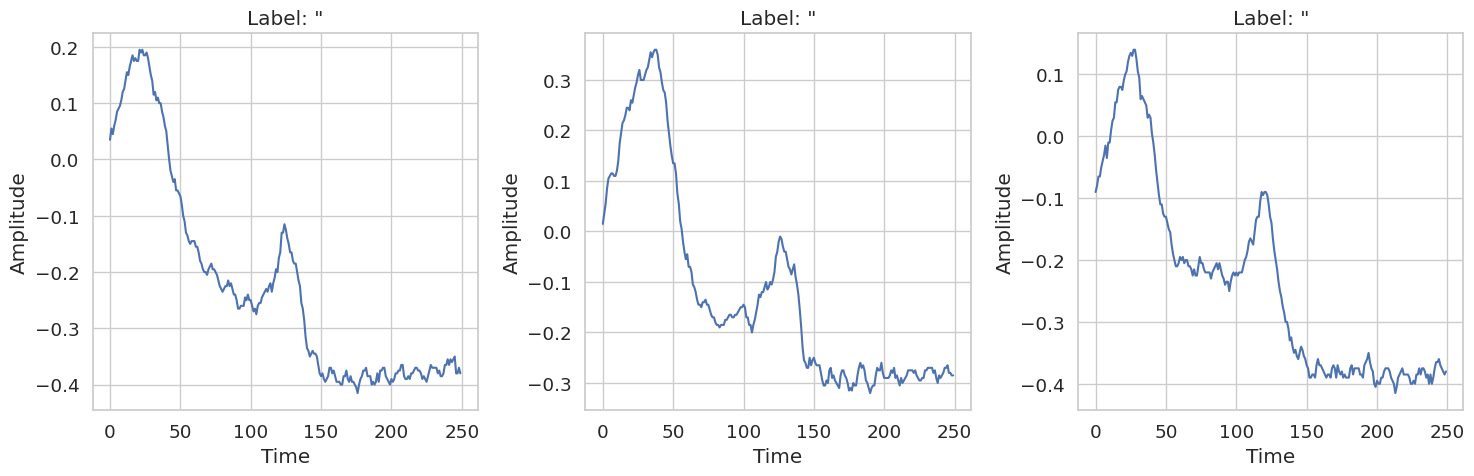

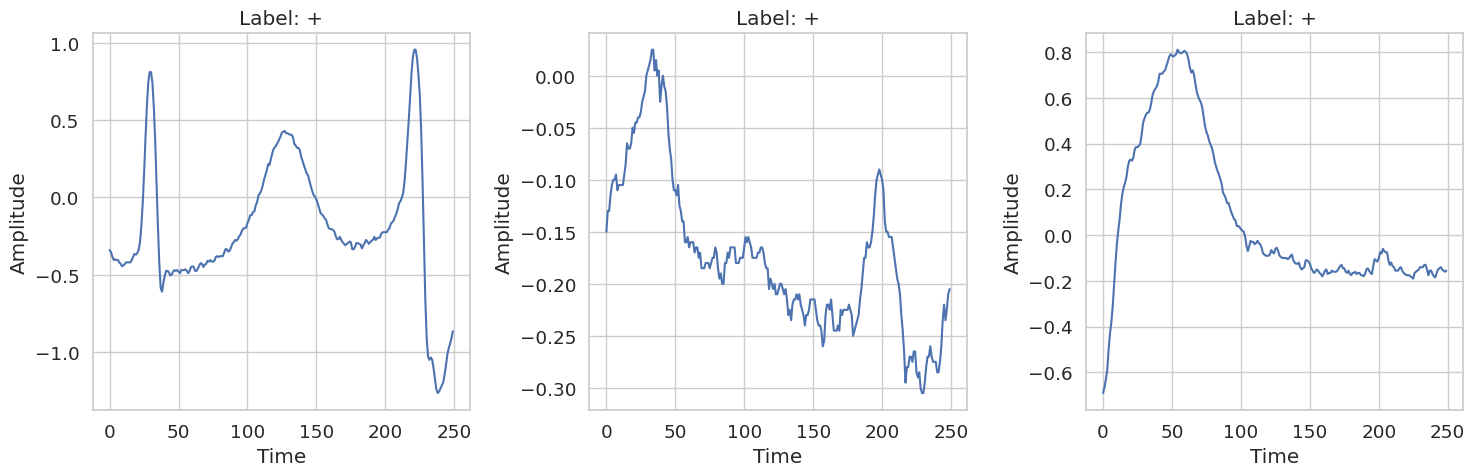

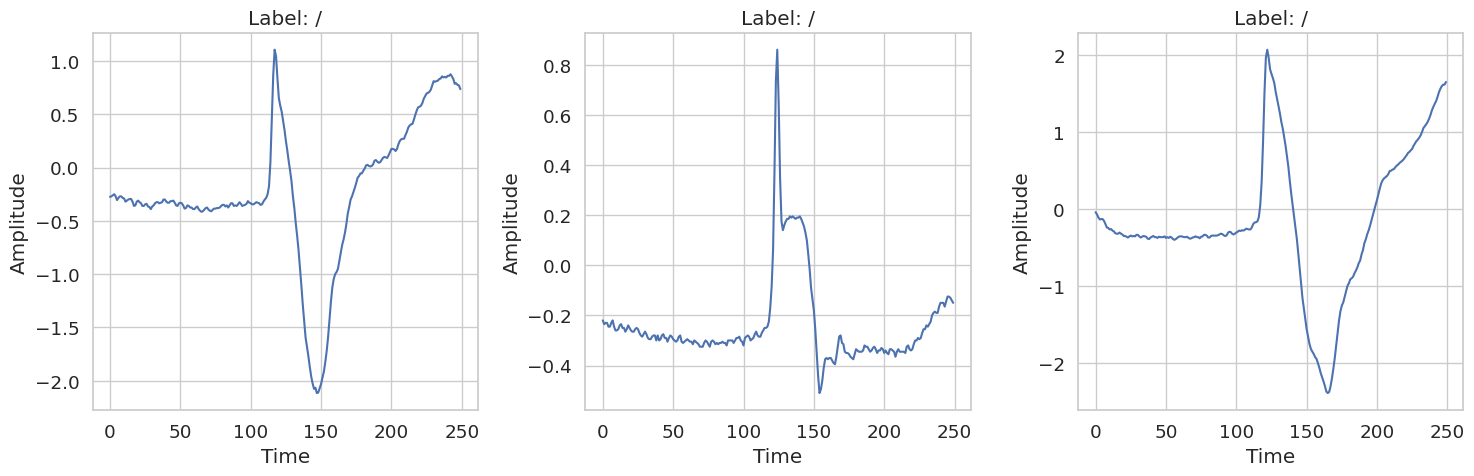

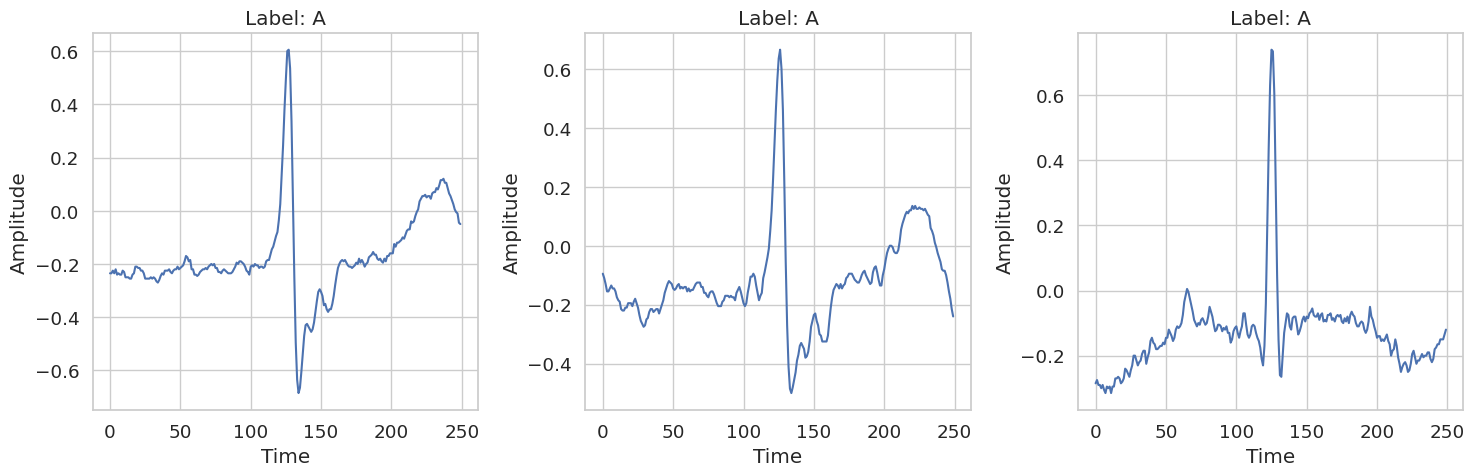

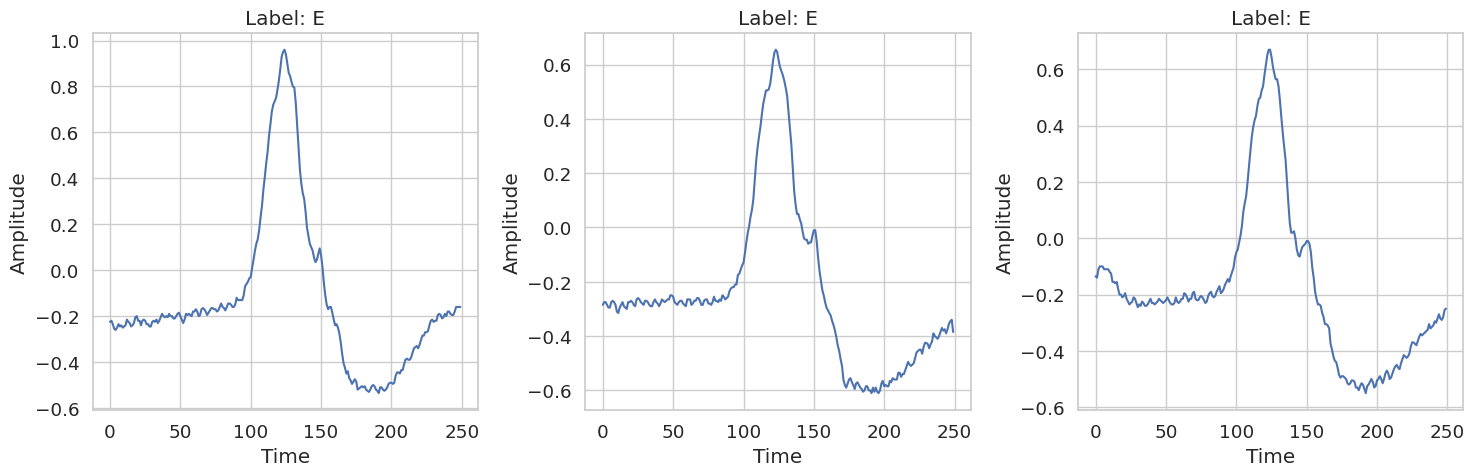

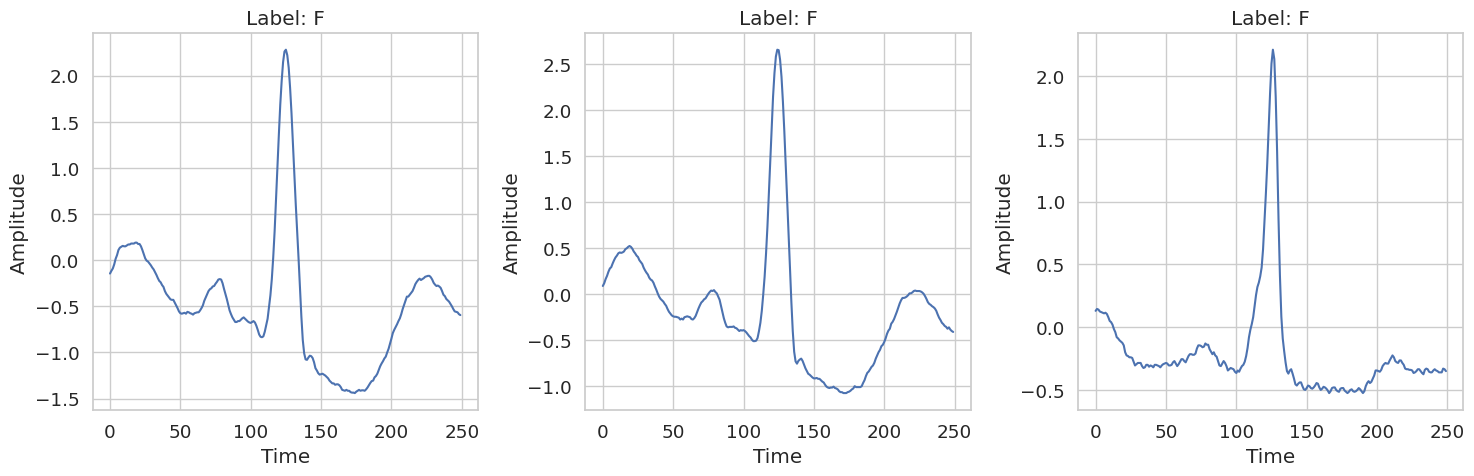

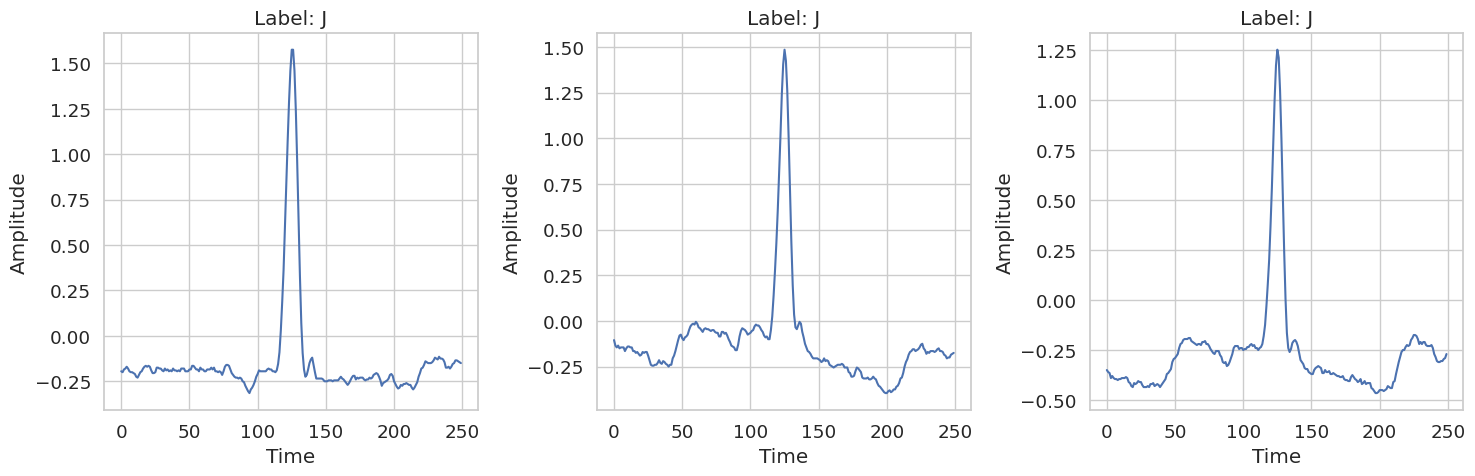

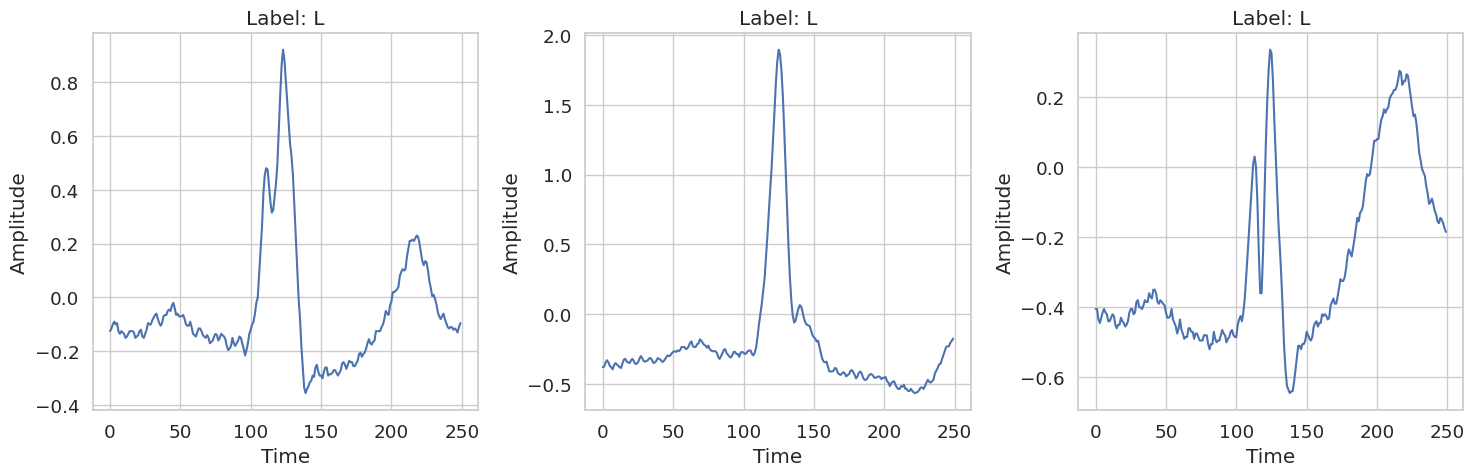

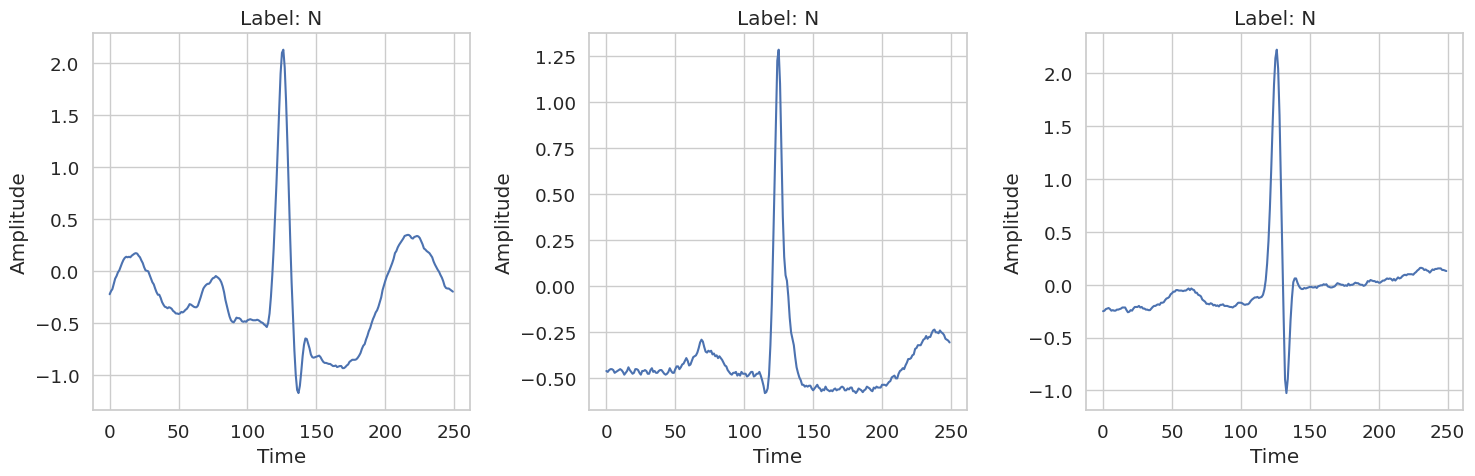

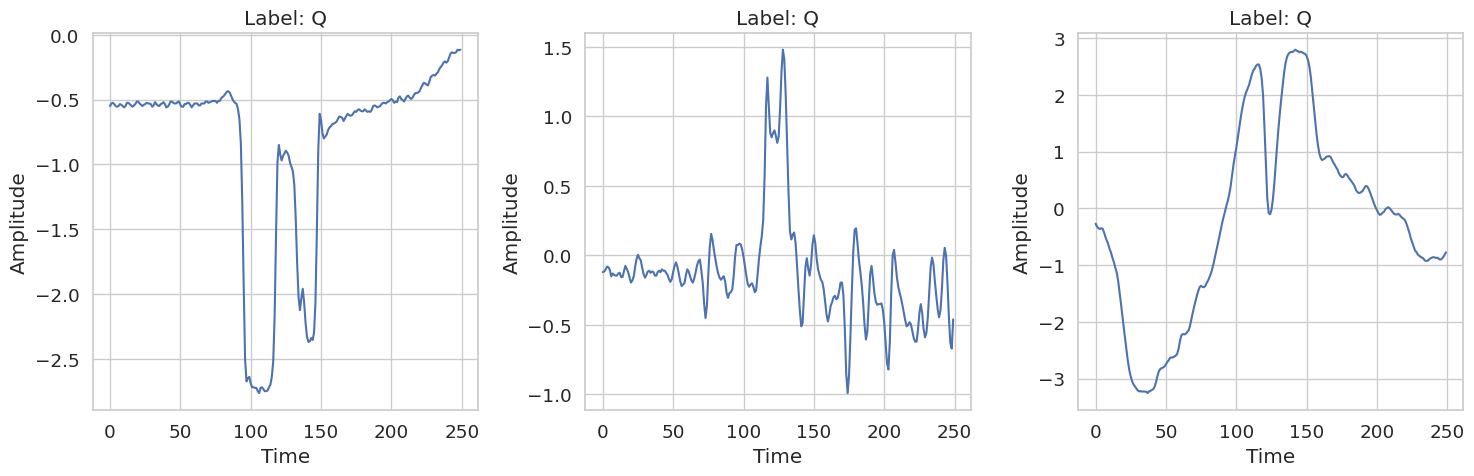

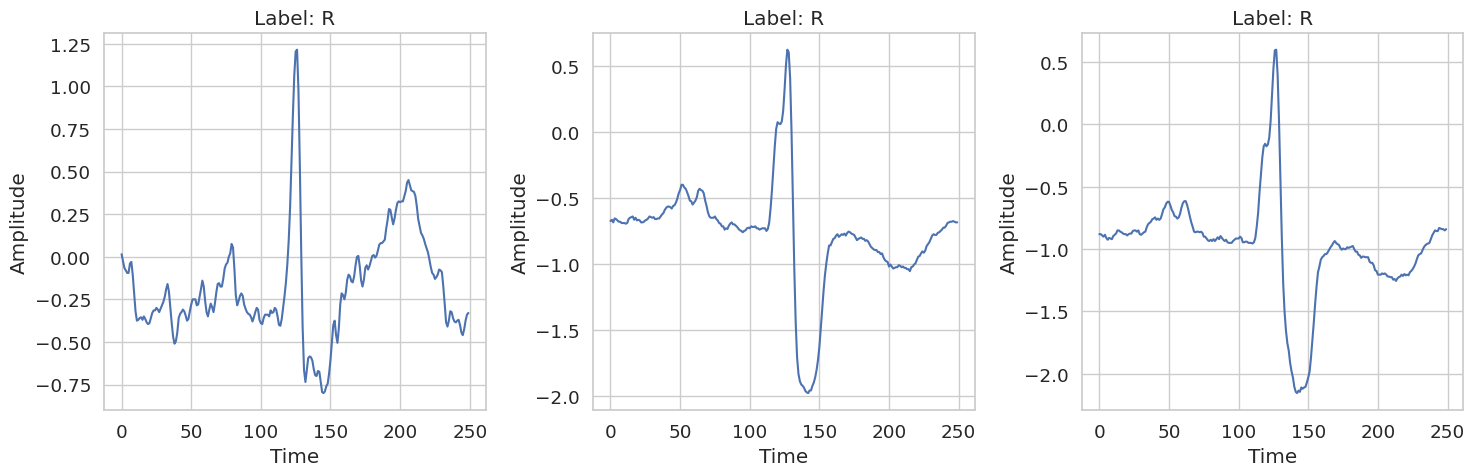

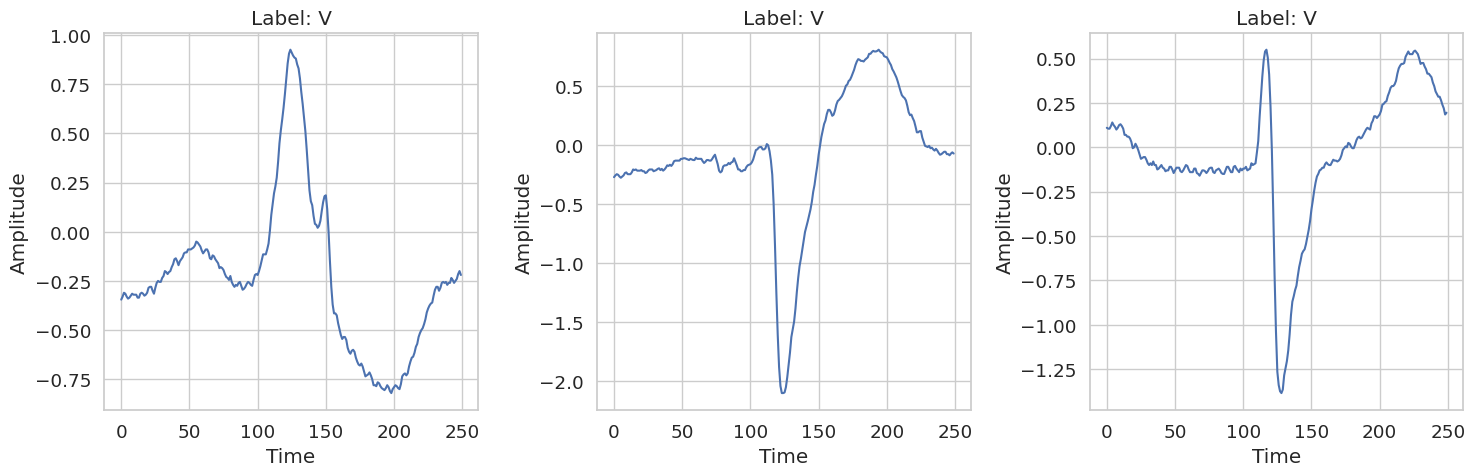

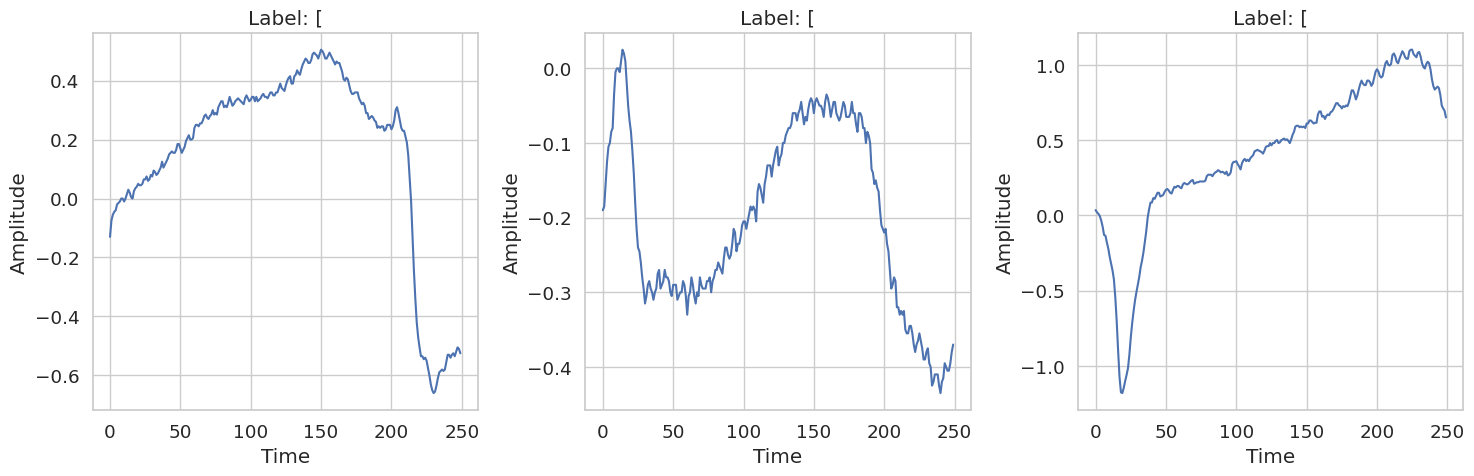

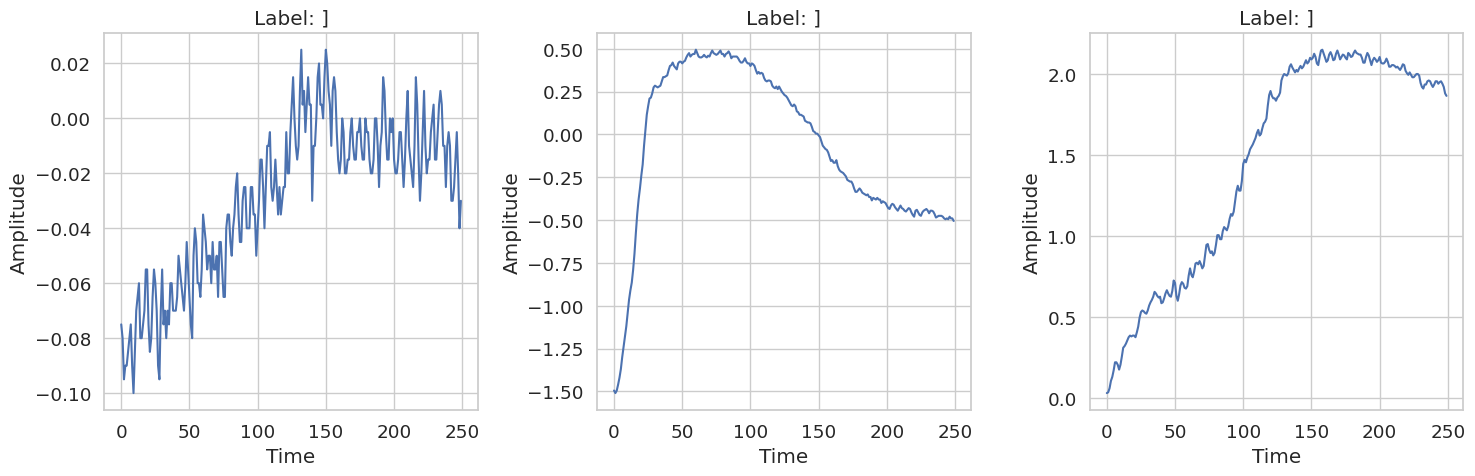

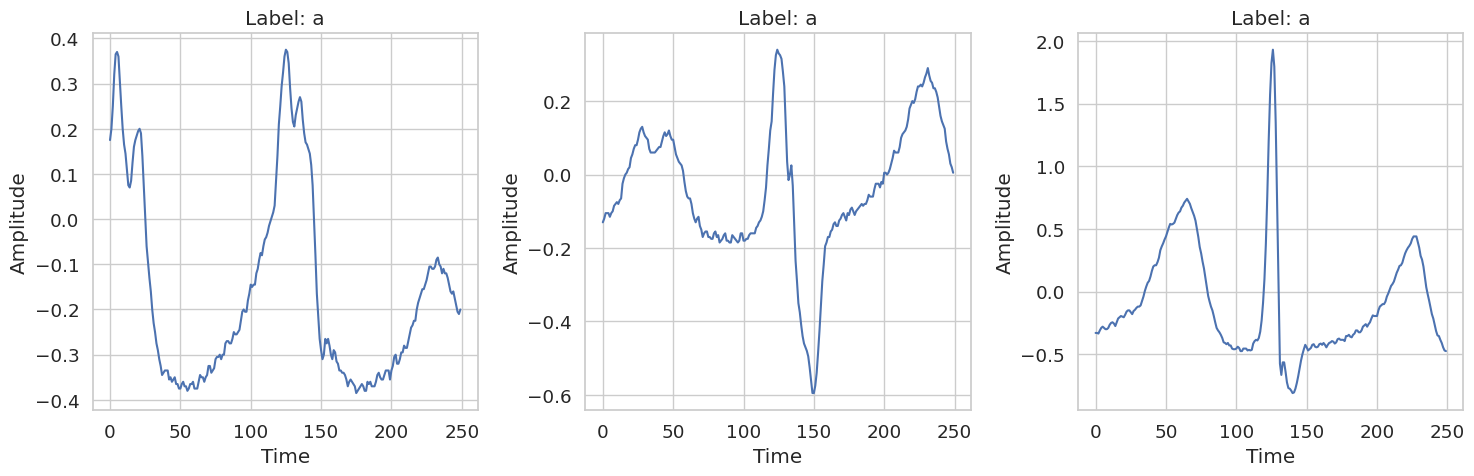

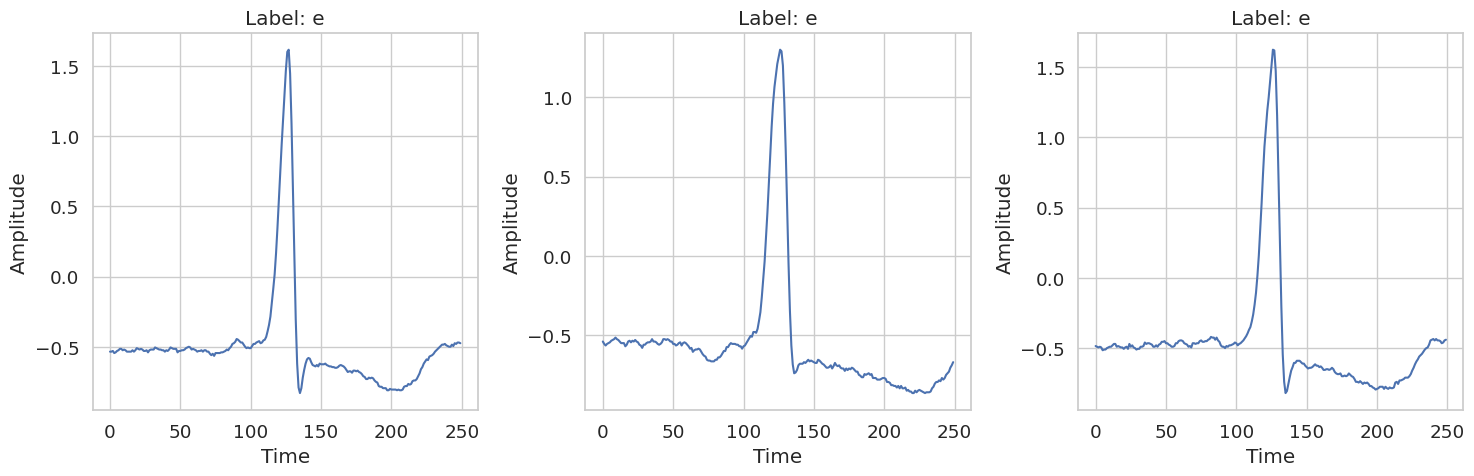

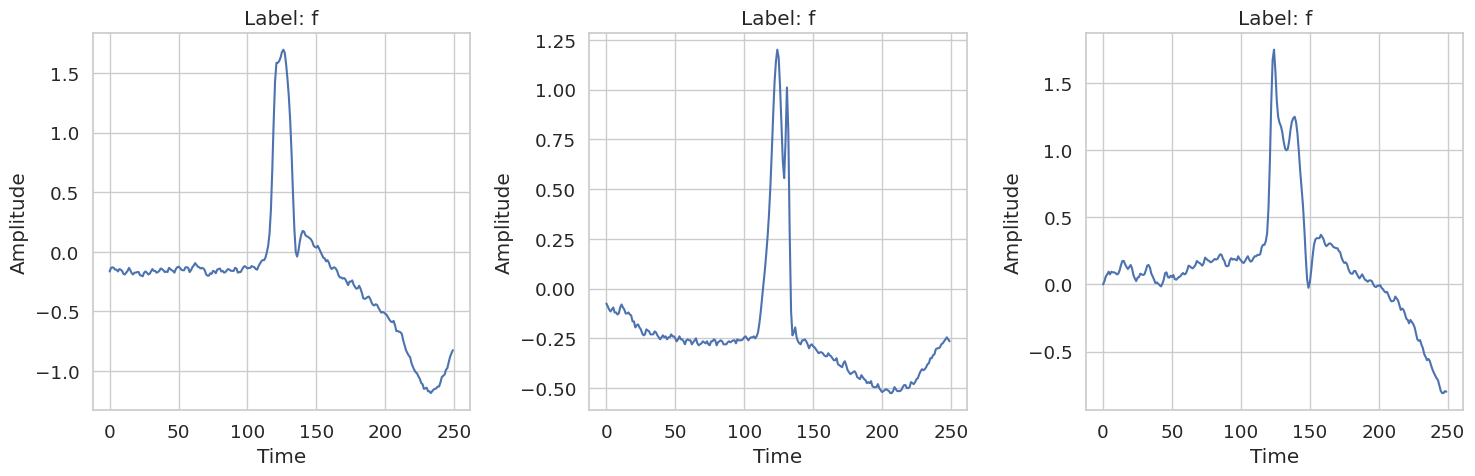

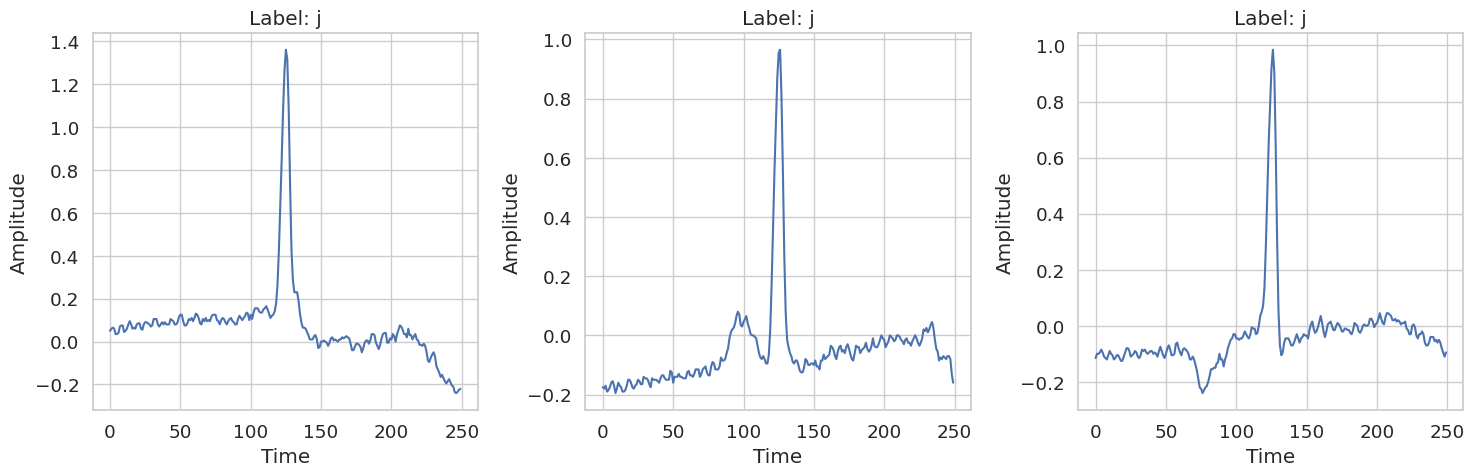

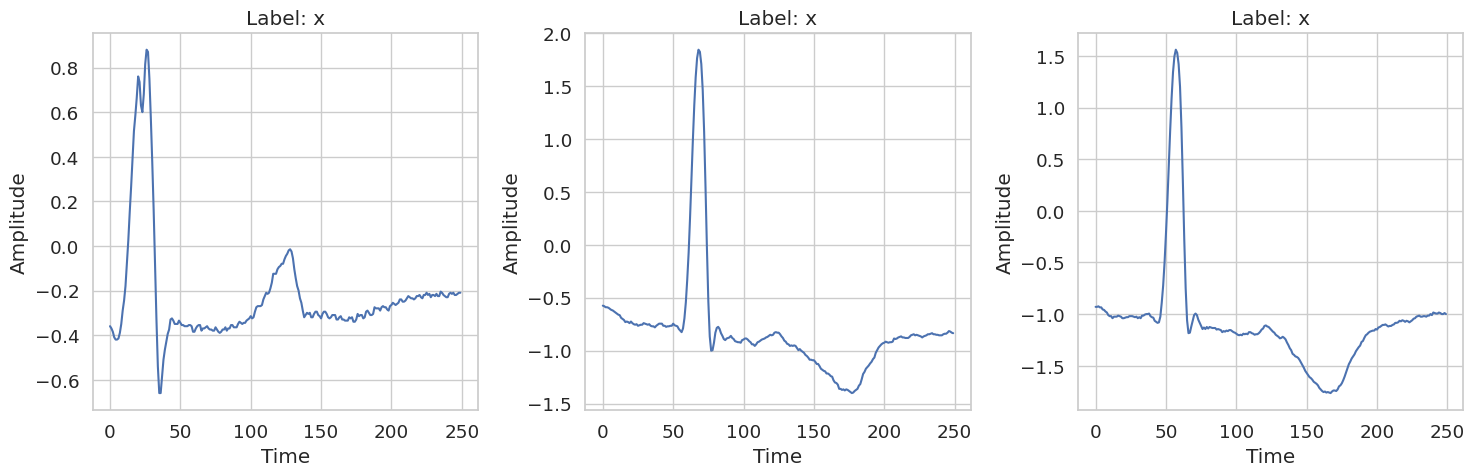

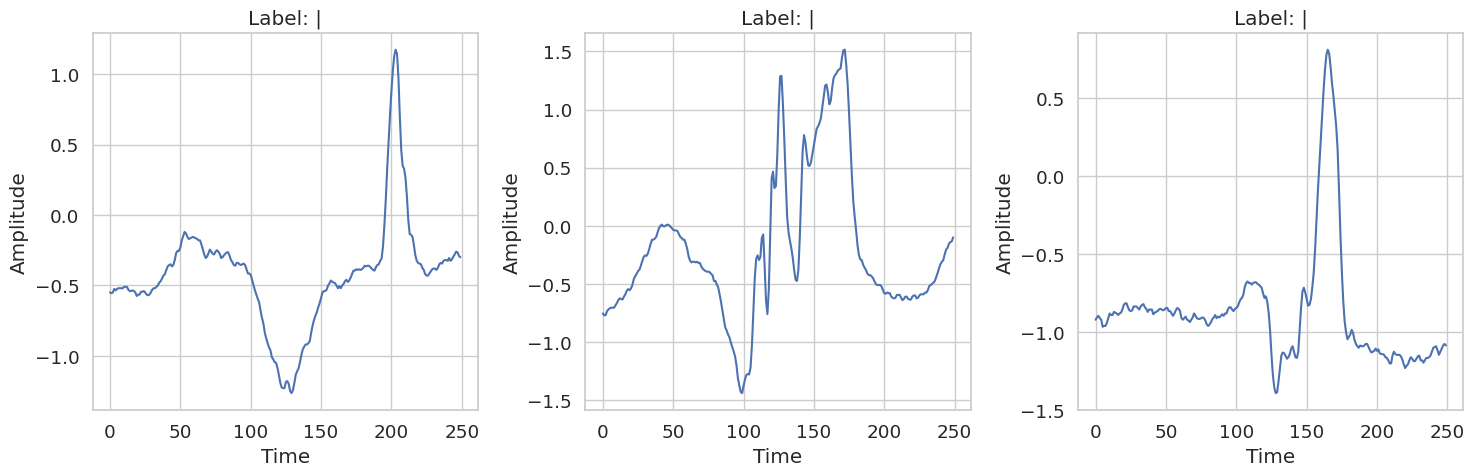

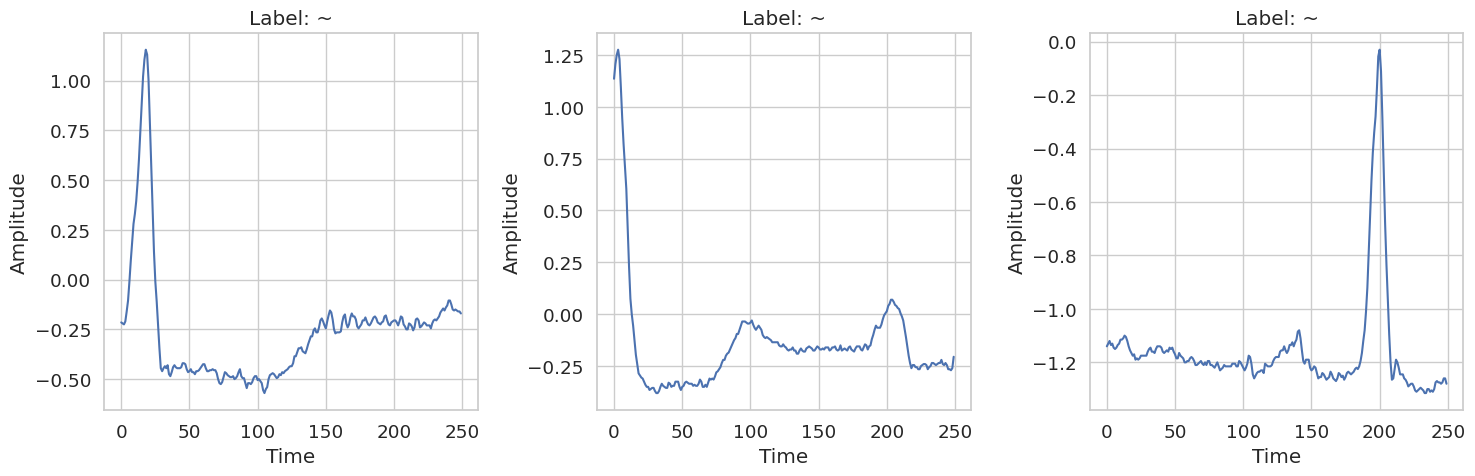

In [17]:
   
    # Plot sample heartbeats
print("\nPlotting sample heartbeats for each label...")
plot_sample_heartbeats(heartbeats, labels)
    


Performing PCA analysis...


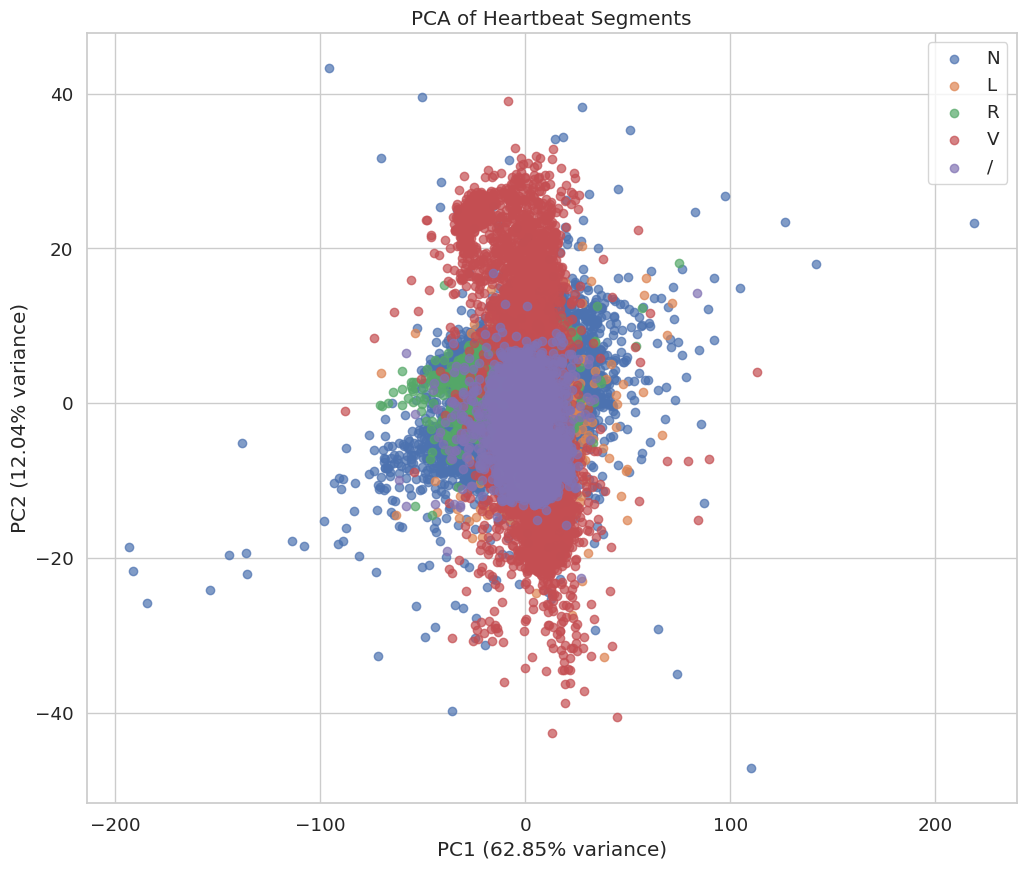

In [18]:
  # Perform PCA analysis
print("\nPerforming PCA analysis...")
heartbeats_pca = perform_pca_analysis(heartbeats, labels)


Performing Advanced Robust PCA analysis...
Performing Robust PCA decomposition (this may take a while)...


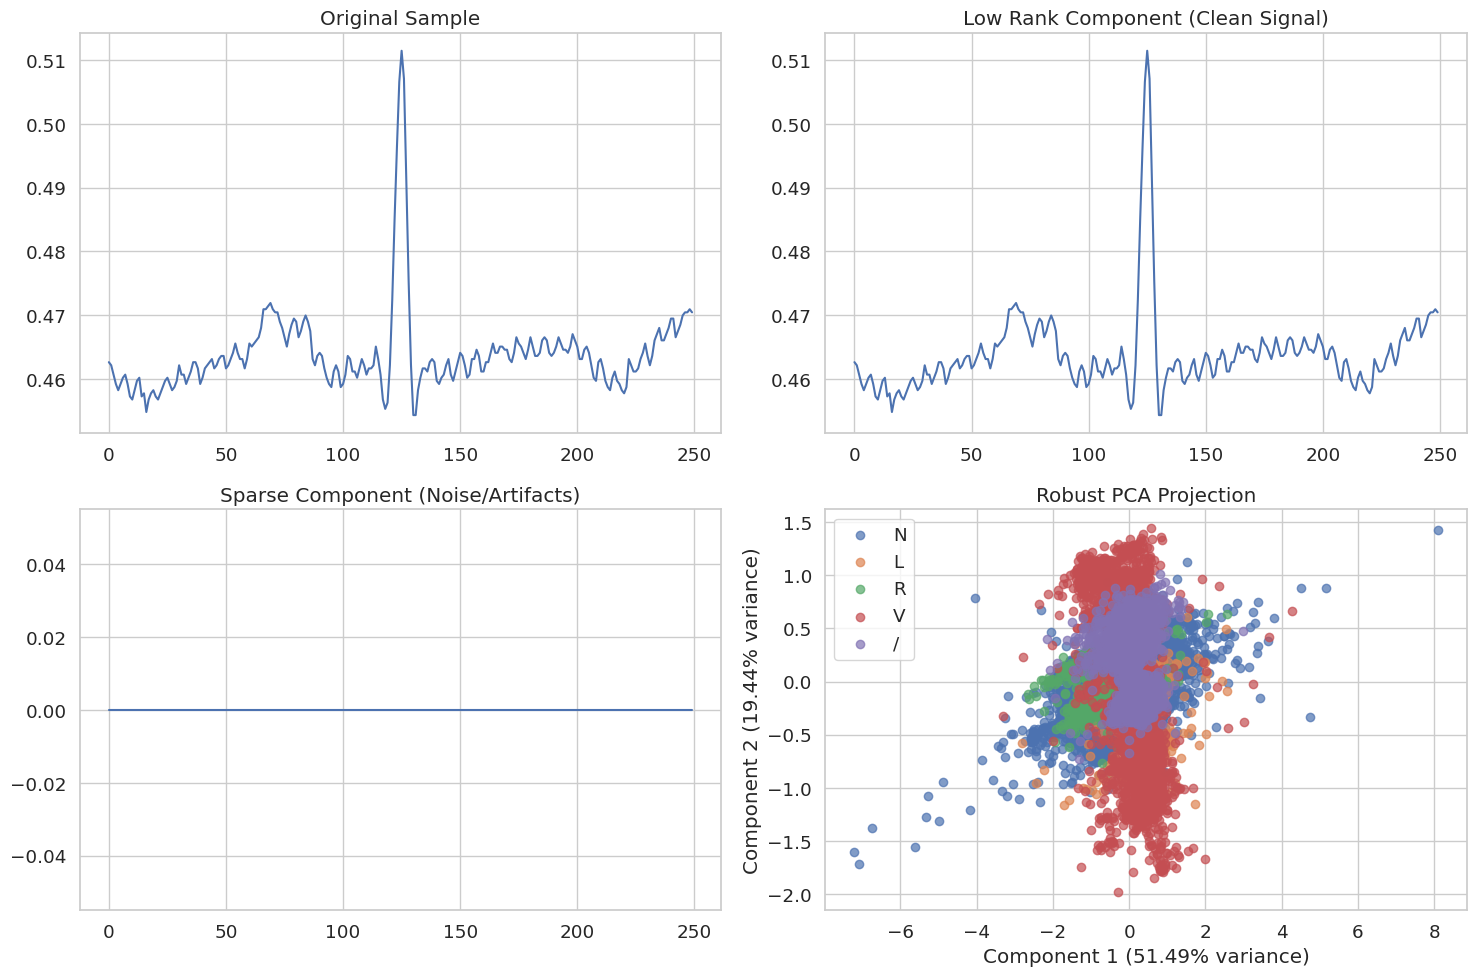

In [20]:
# Perform Advanced Robust PCA analysis
print("\nPerforming Advanced Robust PCA analysis...")
low_rank, sparse, heartbeats_rpca = perform_advanced_robust_pca(heartbeats, labels)




Plotting correlations between average heartbeats...


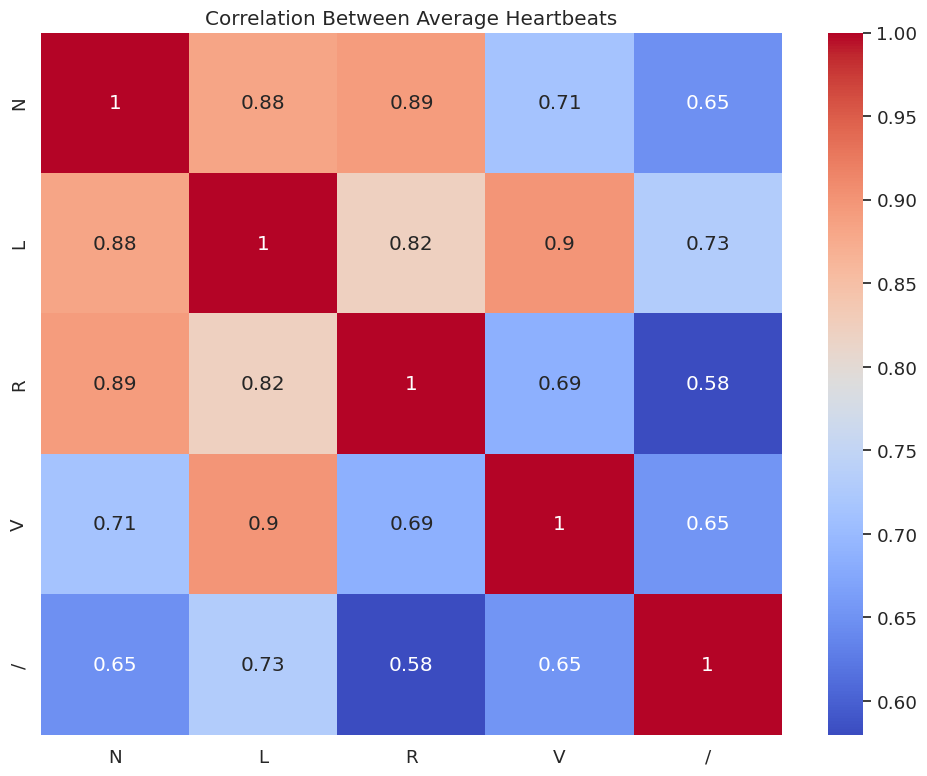

In [25]:
   
    # Plot heartbeat correlations
print("\nPlotting correlations between average heartbeats...")
plot_heartbeat_correlations(heartbeats, labels)
    


We can see that amongst the most frequent classes, N, L, R are the most correlated and even the samples are very similar.

The code bellow was inspired from https://www.kaggle.com/code/gregoiredc/arrhythmia-on-ecg-classification-using-cnn

Number of time points: 1782250
Number of amplitude values: 1782250
Number of heartbeats in class 'V': 7129


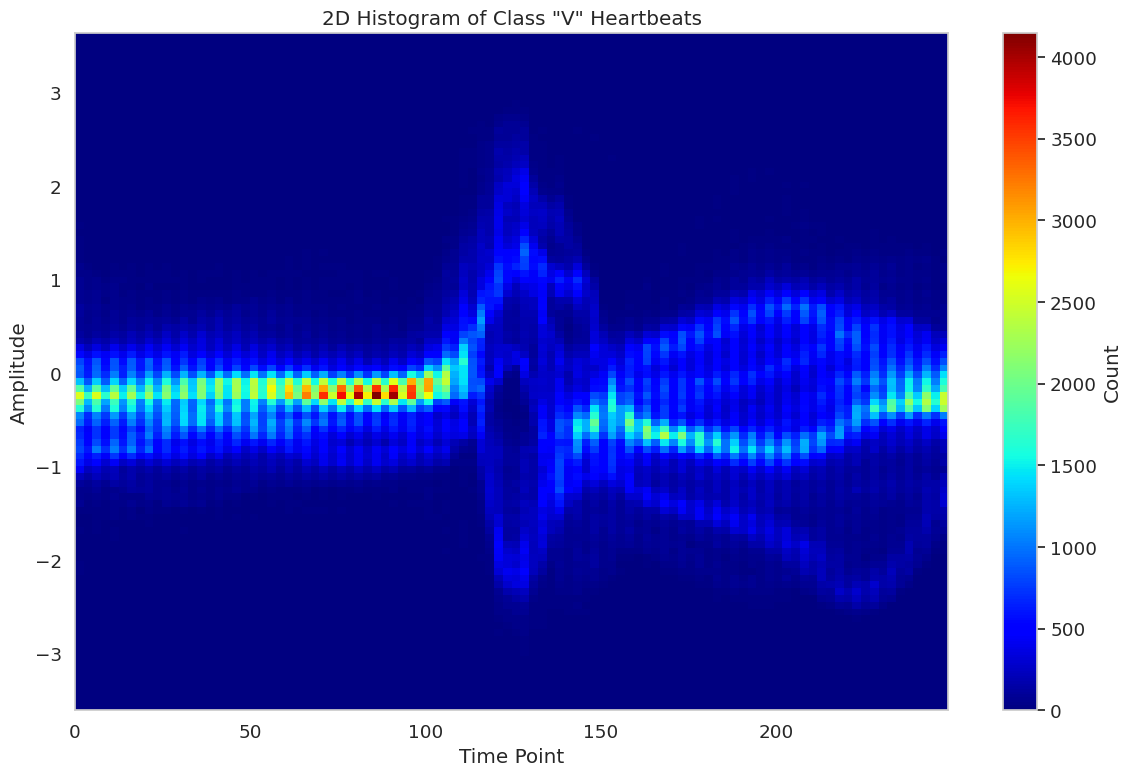

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([  0.  ,   2.49,   4.98,   7.47,   9.96,  12.45,  14.94,  17.43,
         19.92,  22.41,  24.9 ,  27.39,  29.88,  32.37,  34.86,  37.35,
         39.84,  42.33,  44.82,  47.31,  49.8 ,  52.29,  54.78,  57.27,
         59.76,  62.25,  64.74,  67.23,  69.72,  72.21,  74.7 ,  77.19,
         79.68,  82.17,  84.66,  87.15,  89.64,  92.13,  94.62,  97.11,
         99.6 , 102.09, 104.58, 107.07, 109.56, 112.05, 114.54, 117.03,
        119.52, 122.01, 124.5 , 126.99, 129.48, 131.97, 134.46, 136.95,
        139.44, 141.93, 144.42, 146.91, 149.4 , 151.89, 154.38, 156.87,
        159.36, 161.85, 164.34, 166.83, 169.32, 171.81, 174.3 , 176.79,
        179.28, 181.77, 184.26, 186.75, 189.24, 191.73, 194.22, 196.71,
        199.2 , 201.69, 204.18,

In [27]:
def plot_hist_ecg(heartbeats, labels ,label_symbol, min_=0, size=250, bins=50, data_dir="./data"):
    """
    Plot a 2D histogram for a specific heartbeat class showing distribution across time
    
    Parameters:
    label_symbol (str): The heartbeat class label (e.g., 'N', 'V', 'L', etc.)
    min_ (int): Starting point of the heartbeat segment to visualize
    size (int): Ending point of the heartbeat segment to visualize
    bins (int): Number of bins for the 2D histogram
    data_dir (str): Path to the directory containing the MIT-BIH data files
    """
    # First, load the ECG data
    
    # Filter by the specified class
    class_indices = np.where(labels == label_symbol)[0]
    if len(class_indices) == 0:
        print(f"No heartbeats found with label '{label_symbol}'")
        return
    
    # Extract heartbeats of the specified class
    class_heartbeats = heartbeats[class_indices]
    
    # Trim to the specified range
    if size > class_heartbeats.shape[1]:
        size = class_heartbeats.shape[1]
        print(f"Size reduced to {size} (maximum available)")
    
    if min_ >= size:
        print(f"Error: min_ ({min_}) must be less than size ({size})")
        return
    
    # Extract the specified range
    img = class_heartbeats[:, min_:size]
    
    # Flatten the heartbeat data
    img_flatten = img.flatten()
    
    # Create the x-coordinates (time points)
    final1 = np.arange(min_, size)
    for i in range(img.shape[0] - 1):
        tempo1 = np.arange(min_, size)
        final1 = np.concatenate((final1, tempo1), axis=None)
    
    print(f"Number of time points: {len(final1)}")
    print(f"Number of amplitude values: {len(img_flatten)}")
    print(f"Number of heartbeats in class '{label_symbol}': {img.shape[0]}")
    
    # Create the 2D histogram
    plt.figure(figsize=(12, 8))
    h = plt.hist2d(final1, img_flatten, bins=(bins, bins), cmap=plt.cm.jet)
    plt.colorbar(label='Count')
    plt.title(f'2D Histogram of Class "{label_symbol}" Heartbeats')
    plt.xlabel('Time Point')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    
    return h

plot_hist_ecg(heartbeats, labels,'V', min_=0, size=250, bins=100)
